In [12]:
import logging
from math import trunc
from operator import itemgetter
from pprint import pprint
import re
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel
from gensim.models import TfidfModel
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.test.utils import datapath
from nltk.corpus import stopwords
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
from rdflib import Namespace, XSD
from rdflib.namespace import SKOS
from scipy.stats import percentileofscore
from sklearn.feature_extraction.text import TfidfVectorizer
import sparql_util as su
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import spacy
from tqdm.notebook import tqdm_notebook

###

tqdm_notebook.pandas()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop_words = stopwords.words('english')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/victor.vulovic/Library/Caches/pypoetry/virtualenvs/match-2141-8E5MUDZ4-py3.9/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['trunc']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## All Dice.com jobs in production

In [300]:
prodjobs = pd.io.json.read_json('all_prod_jobs.json', lines=True)

In [301]:
len(prodjobs)

77142

In [302]:
prodjobs.head()

,brandId,job_description,job_skills,enriched_epoch_datetime,job_title,id
0,dice,"Our client, a global network of professional f...","[Release, Management, PowerPoint, Excel, Adobe]",1.620001e+09,Release Management Coordinator,NaN
1,dice,Fully Remote Now offered for the following tim...,"[Computer, HTTP, Test, Development, Python, Ja...",1.620001e+09,Back End Software Engineer,NaN
2,dice,If you have a strong interest in joining a hig...,[Manager],1.620001e+09,Senior Product Manager,NaN
3,dice,DevOps Engineer - Must have active TS/SCI Thi...,"[Engineer, Systems, Python]",1.620002e+09,DevOps Engineer,NaN
4,dice,Senior DevOps Engineer - Fully Remote This Jo...,[Engineer],1.620001e+09,Senior Devops Engineer,NaN


In [306]:
seniority_patterns = [r'[sj]r._level_', r'^[seju]{2}nior[,_]*', r'[seju]{2}nior-?_', r',*_\(*[seju]{2}nior\)*_*', r'[seju]{2}nior\.',
                      r'senior[\/-]lead_', r'-[seju]{2}nior', r'[seju]{2}nior\/', r'[seju]{2}nior-level_', r'\/contract\/[seju]{2}nior',
                      r'\/[seju]{2}nior', r'[seju]{2}nior[-_]mid_', r'\/*[seju]{2}nior[-_]*level_?', r'\/*mid[-_]*level_?', r'mid[ -_to]{4}[seju]{2}nior[ -_]level[ -_]',
                      r'mid\/sr_level_', r'[-_]{,3}mid_level', r'[-_]{,3}mid', r'_level_\d+']
seniority_patterns = '|'.join(seniority_patterns)
prodjobs['match_column'] = prodjobs['job_title'].str.lower().str.replace(r'[ \(\)]|\\\/', '_', regex=True).str.replace(seniority_patterns, '', regex=True)

In [307]:
prodjobs[prodjobs['match_column'].str.contains('junior|senior|mid', case=False)]

,brandId,job_description,job_skills,enriched_epoch_datetime,job_title,id,match_column
19861,dice,"HI, One of my client is looking for below re...","[perl, pl/sql, Shell Scripting]",NaN,Role:SeniorPerl&PL/SQLdeveloper,5907b2960fbe6154562ba6b620a31eb9,role:seniorperl&pl/sqldeveloper
66901,dice,"Mostly remote , Ongoing Long term Contract py...","[Alteryx, Python, ETL]",NaN,Alteryx Developer :Senior: Immediate Interviews,41ac01a9d04bad9aa94e53db5ba22bde,alteryx_developer_:senior:_immediate_interviews


In [308]:
top_jobs = pd.DataFrame(prodjobs['match_column'].value_counts())
top_jobs

,match_column
software_engineer,1096
java_developer,836
business_analyst,612
.net_developer,593
project_manager,589
...,...
associate_dca_engineer,1
technician_-_testing,1
motor_control_design_engineer,1
technical_services_operations_administrator,1


## Load all unique job titles from Neptune

In [309]:
SPARQL_ENDPOINT = "https://dev-taxonomy-neptune-cluster.cluster-cab44ucmi0fe.us-east-1.neptune.amazonaws.com:8182/sparql"
sparql = SPARQLWrapper(SPARQL_ENDPOINT)
DHI = Namespace("https://dhigroupinc.com/ns/core#")

In [325]:
query = f"""
PREFIX skos: <{SKOS}>
PREFIX dhi: <{DHI}>

SELECT DISTINCT ?title
WHERE {{
    ?title a dhi:JobTitle .
    ?title skos:prefLabel ?prefLabel .
    filter langMatches(lang(?prefLabel), 'en-US')

}}
Group BY ?title

"""

sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
kg_jobs = su.sparql2df(results)
kg_jobs

,title
0,https://dice.com/jobs/titles/Production_Manager
1,https://dice.com/jobs/titles/Social_Media_Coor...
2,https://dice.com/jobs/titles/Software_Developm...
3,https://dice.com/jobs/titles/Logistics_Coordin...
4,https://dice.com/jobs/titles/Datastage_Adminis...
...,...
1604,https://dice.com/jobs/titles/Communication_Sys...
1605,https://dice.com/jobs/titles/Consultant_Busine...
1606,https://dice.com/jobs/titles/Ariba_Project_Imp...
1607,https://dice.com/jobs/titles/Principal_FPGA_El...


In [326]:
kg_jobs['matching_column'] = kg_jobs['title'].str.lower().str.replace(r'https://dice.com/jobs/titles/', '')

/var/folders/34/m8mq2k417_39tm4hbb0078gwckj2kw/T/ipykernel_7172/3401214892.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  kg_jobs['matching_column'] = kg_jobs['title'].str.lower().str.replace(r'https://dice.com/jobs/titles/', '')


In [327]:
tj = top_jobs.iloc[:100].reset_index().rename(columns={'index': 'matching_column', 'match_column': 'count'})
tj

,matching_column,count
0,software_engineer,1096
1,java_developer,836
2,business_analyst,612
3,.net_developer,593
4,project_manager,589
...,...,...
95,mainframe_developer,48
96,cyber_security_analyst,48
97,controls_engineer,47
98,data_modeler,46


### Top 20 most common jobs histogram

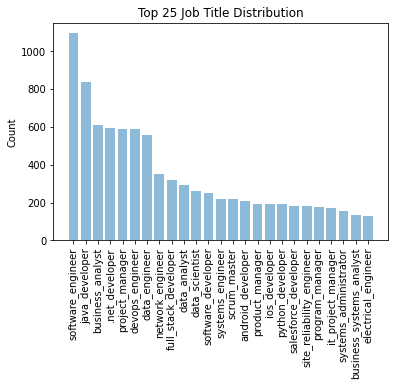

In [328]:
title = 'Top 25 Job Title Distribution'
plt.bar(tj['matching_column'].iloc[:25], tj['count'].iloc[:25], align='center', alpha=0.5)
plt.xticks(tj['matching_column'].iloc[:25], rotation=90)
plt.ylabel('Count')
plt.title(title)
plt.show()

In [329]:
lda_training = kg_jobs.merge(tj).merge(prodjobs, left_on='matching_column', right_on='match_column')
lda_training

,title,matching_column,count,brandId,job_description,job_skills,enriched_epoch_datetime,job_title,id,match_column
0,https://dice.com/jobs/titles/Web_Developer,web_developer,90,dice,"Location: Houston, TX Position: Senior Web Dev...","[.NET, SQL, React.js, AngularJS, UI]",NaN,Senior Web Developer,2756cb413a30a0b0b972828e571fec2d,web_developer
1,https://dice.com/jobs/titles/Web_Developer,web_developer,90,dice,"Thorlabs is looking for a skilled, motivated, ...","[SQL, HTML]",NaN,Web Developer,ee2f91c5bd034907b642e64edfcd7f04,web_developer
2,https://dice.com/jobs/titles/Web_Developer,web_developer,90,dice,"Web Developer Tech Stack: PHP, MySQL, GIT, JIR...","[PHP, MySQL, GIT, JIRA, Apache]",NaN,Web Developer,2ec4704334900360f2ccb757f842712b,web_developer
3,https://dice.com/jobs/titles/Web_Developer,web_developer,90,dice,Codeworks is an IT Services firm in SE Wiscons...,"[C#, ASP.NET, .NET, Web API, HTML, CSS, JavaSc...",NaN,Web Developer,ba01ed1ca9a9f216eba6e2448ab518c4,web_developer
4,https://dice.com/jobs/titles/Web_Developer,web_developer,90,dice,"Responsibilities: Creates standards-based, sem...","[React JS, react.js, javascript, HTML, UX]",NaN,Web Developer,29ce4ca7b95dc302d048c6cb37b81594,web_developer
...,...,...,...,...,...,...,...,...,...,...
10434,https://dice.com/jobs/titles/SQL_Developer,sql_developer,60,dice,RESPONSIBILITIES: Kforce has a client in Boca ...,NaN,NaN,SQL Developer,dd68c773608f22d59d35d5a79a249af0,sql_developer
10435,https://dice.com/jobs/titles/SQL_Developer,sql_developer,60,dice,Career Opportunity: Job Title: SQL Developer ...,[sql developer],NaN,SQL Developer,5d16582ae6bb187ef6d7c54be0cb777f,sql_developer
10436,https://dice.com/jobs/titles/SQL_Developer,sql_developer,60,dice,job summary: General Summary Rnadstad is loo...,[Senior SQL Developer],NaN,Senior SQL Developer,c54862d37d7e155fb720bb41fb7a0860,sql_developer
10437,https://dice.com/jobs/titles/SQL_Developer,sql_developer,60,dice,job summary: Randstad Technologies is searchi...,[SQL Developer],NaN,SQL Developer,82645a324d229f4a08a925d6bcbe0e63,sql_developer


In [36]:
# kg_jobs.to_csv('kg_jobs.csv')

In [330]:
lda_training = lda_training[['title', 'matching_column', 'count', 'job_description', 'job_skills', 'job_title']]

In [1203]:
re.sub('[•™\\#\\*\\|\\(\\)\\?\\@,:“”·–_-]+|\\.(?!\\w+)', '', sample + ' large .net dev healthcare client in NC.')

'US Tech Solutions is seeking a Data Scientist for a 3 month contract position with a client in Burbank CA   Job Poster  large .net dev healthcare client in NC'

In [458]:
info_tech = ' IT |i\\.t\\.|I\\.T\\.'

In [1226]:
# fixes examples like "this is a skill.Experience" while avoiding key instances of periods in terms like ASP.NET
period_typos = '(?![a-z]+)\\.(?=[A-z][a-z]+)'

In [1300]:
# corrects for some formatting issues that result in things like "your skillsQualifications"
camel_case_pattern = '(?<=[a-z])([A-Z])(?! )'

In [1299]:
re.sub(r"(?<=[a-z])([A-Z])(?! )", r" \1", 'SaaS preferredExperience')

'SaaS preferred Experience'

In [753]:
regex_ref = {
    'punctuation': {
        'pattern': r'[•™\#\*\|\(\)"\?\@,:;“”·–_]+|\.(?!\w+)',
        'repl': r''
    },
    'slashes': {
        'pattern': r'/|-',
        'repl': r' '
    }, 
    'ampersand': {
        'pattern': r'&',
        'repl': r'and'
    }, 
    'info_tech': {
        'pattern': r' IT |i\.t\.|I\.T\.',
        'repl': r' information technology '
    }, 
    'period_typos': {
        'pattern': r'(?![a-z]+)\.(?=[A-z][a-z]+)',
        'repl': r' '
    },
    'camel_case': {
        'pattern': r'(?<=[a-z])([A-Z])(?! )',
        'repl': r' \1'
    },
    'unicode': {
        'pattern': r'\x01',
        'repl': r''
    },
    'urls': {
        'pattern': r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)|[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)',
        'repl': r''
    }
}

In [332]:
url_patterns = [r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)',
                r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)']
urls = '|'.join(url_patterns)

lda_training[lda_training['job_description'].str.contains(urls, regex=True)]

/var/folders/34/m8mq2k417_39tm4hbb0078gwckj2kw/T/ipykernel_7172/3692501400.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  lda_training[lda_training['job_description'].str.contains(urls, regex=True)]


,title,matching_column,count,job_description,job_skills,job_title
0,https://dice.com/jobs/titles/Web_Developer,web_developer,90,"Location: Houston, TX Position: Senior Web Dev...","[.NET, SQL, React.js, AngularJS, UI]",Senior Web Developer
1,https://dice.com/jobs/titles/Web_Developer,web_developer,90,"Thorlabs is looking for a skilled, motivated, ...","[SQL, HTML]",Web Developer
3,https://dice.com/jobs/titles/Web_Developer,web_developer,90,Codeworks is an IT Services firm in SE Wiscons...,"[C#, ASP.NET, .NET, Web API, HTML, CSS, JavaSc...",Web Developer
4,https://dice.com/jobs/titles/Web_Developer,web_developer,90,"Responsibilities: Creates standards-based, sem...","[React JS, react.js, javascript, HTML, UX]",Web Developer
6,https://dice.com/jobs/titles/Web_Developer,web_developer,90,Job Description: The primary purpose of this r...,"[Bootstrap, CSS, HTML5, Attention to detail, J...",Web Developer
...,...,...,...,...,...,...
10419,https://dice.com/jobs/titles/SQL_Developer,sql_developer,60,"We have a Contract position for ""SQL Developer...",[PostgresQL],SQL Developer
10420,https://dice.com/jobs/titles/SQL_Developer,sql_developer,60,"Role : SQL Developer Location : Coppell, Texas...","[Microsoft SQL Server, T-SQL, SQL queries, Mic...",SQL Developer
10425,https://dice.com/jobs/titles/SQL_Developer,sql_developer,60,Our client will entertain Remote Employees - b...,[sql],SQL developer
10430,https://dice.com/jobs/titles/SQL_Developer,sql_developer,60,SQL Developer GDH Consulting is looking for a ...,"[ACT, PL/SQL, Security, SQL, T-SQL]",SQL Developer


In [1324]:
re.sub('\\x01', "", '\x01eplacement')

'eplacement'

In [1303]:
re.sub(camel_case_pattern, r" \1", re.sub(punc_regex, "", re.sub(period_typos, ' ', lda_training.iloc[3]['job_description'] + ' ASP.NET')))

"SaaS AWS Spark  This Jobot Job is hosted by Derek Cox Are you a fit Easy Apply now by clicking the Apply Now button and sending us your resume Salary $100  $160 per year  A bit about us  We are a Cloud Security SaaS startup looking for ambitious engineers to join a small team We create the first software cloudnative security and compliance platform built on a graph data model We just had a 20 million series A round Are you passionate about helping customers understand their data Our product is cloud native and some of our customers are Reddit Databricks and Auth0 which helps them manage and monitor their cloud infrastructure  You will be responsible for determining the tools technologies and approach to helping customers analyze and interpret their data We are a data platform for a customer's digital cloud infrastructure The tools we build are used by security and operation teams to monitor all of their digital assets It is our responsibility to help them understand this data via adva

In [1202]:
re.sub(r"(?<=[a-z])([A-Z])", r" \1", lda_training.iloc[0]['job_description'])

'Data Scientist – Ground-breaking Biopharma   My client is a leading innovative Biopharma who are working on the most cutting edge technologies within cell and gene therapies specifically targeting oncology. You will be joining a world leading team of scientists and Data Science professionals based in San Francisco, who are at the top of their game and are constantly pushing the boundaries of what we believe possible within T-Cell research.   Roles & Responsibilities: As a Data Scientist you will be working on a novel bioinformatics platform to research personalised T-cell therapies.You will use your knowledge of *omics data analysis to be a key member in developing novel analytical and computational methods for single cell & T-cell datasets.Using your strong communication skills you will be a focal point for interactions between the team and internal stakeholders across the company.Being an expert within Python/R you will be able to write code whilst working within a Linux system.  Qu

In [ ]:
# remove unuseful punctuation without eliminating key tech usages of "."
# e.g., ".NET" should be distinct from "net"
punc_regex = '[•™\\#\\*\\|\\(\\)"\\?\\@,:;“”·–_-]+|\\.(?!\\w+)'

In [464]:
lda_training.iloc[90:100].apply(lambda x: print(x.name, 
                                                re.sub('&',
                                                       'and', 
                                                       re.sub('/', 
                                                              ' ', 
                                                              re.sub(punc_regex, 
                                                                     '', 
                                                                     x['job_description'])
                                                             )
                                                      )
                                               ), 
                                axis=1)

90 Apex Systems is looking for a Data Scientist for a large healthcare client in NC 100% Remote Open to contract and direct hire Data Scientist Location Remote in NC SC VA GA Duration 6 month Contract Contract to Hire OR Direct Hire Salary $110k+ with flexibility The Data Scientist collaborates with team members to improve the quality and effectiveness of patient care by leveraging data to generate new knowledge The Data Scientist must be proficient in employing large scale data analytics to derive actionable insights Develops descriptive and predictive models from conception to completion and longterm support Excellent communication and interpersonal skills are required The Data Scientist will interface and collaborate with technical and nontechnical team members to accomplish goals and ensure business needs are met The Data Scientist must have the ability to synthesize novel ideas and flourish in an environment where the need for new analytical capabilities is constant Additionally t

90    None
91    None
92    None
93    None
94    None
95    None
96    None
97    None
98    None
99    None
dtype: object

In [312]:
regex_ref

{'punctuation': {'pattern': '[•™\\#\\*\\|\\(\\)"\\?\\@,:;“”·–_-]+|\\.(?!\\w+)',
  'repl': ''},
 'slashes': {'pattern': '/', 'repl': ' '},
 'ampersand': {'pattern': '&', 'repl': 'and'},
 'info_tech': {'pattern': ' IT |i\\.t\\.|I\\.T\\.',
  'repl': ' information technology '},
 'period_typos': {'pattern': '(?![a-z]+)\\.(?=[A-z][a-z]+)', 'repl': ' '},
 'camel_case': {'pattern': '(?<=[a-z])([A-Z])(?! )', 'repl': ' \x01'},
 'unicode': {'pattern': '\\x01', 'repl': ''}}

In [313]:
def IT_conversions(text, regex):
    info_tech = regex['info_tech']
    information_technology = re.sub(info_tech['pattern'], info_tech['repl'], text)
    return information_technology

In [ ]:
def clean_urls(text, regex):
    urls = regex['urls']
    return re.sub(urls['pattern'], urls['repl'], text)

In [775]:
def remove_punctuation(text, regex):
    punc_regex = regex['punctuation']
    slashes = regex['slashes']
    ampersand = regex['ampersand']
    period_typos = regex['period_typos']
    unicode = regex['unicode']
    
    text = re.sub(punc_regex['pattern'], punc_regex['repl'], text)
    text = re.sub(slashes['pattern'], slashes['repl'], text)
    text = re.sub(ampersand['pattern'], ampersand['repl'], text)
    text = re.sub(period_typos['pattern'], period_typos['repl'], text)
    text = re.sub(unicode['pattern'], unicode['repl'], text)
    return text

In [1098]:
custom_stopwords = open('nltk_cornell_stop.txt', 'r').read()
custom_stopwords = custom_stopwords.split(',')
for word in ['for', 'in', 'of', 'on', 'to']:
    custom_stopwords.remove(word)

additional_stops = [
    '401k', 'accessibility', 'accountability', 'active_learning', 'active_listening', 'act', 'adaptability', 
    'adapter', 'administration', 'aim', 'algorithms', 'apple', 'architecture', 'archiving', 'articulate',
    'audio', 'audit', 'authentication', 'automation', 'aviation', 'backup', 'banking', 'bind', 'budget',
    'brand', 'buyer', 'change_control', 'collaboration', 'commerce', 'communication', 'compliance', 'computer', 
    'computer_literacy', 'configuration', 'conflict_resolution', 'consulting', 'cost_reduction',
    'creativity', 'critical_thinking', 'curriculum', 'customer_satsifaction', 'customization', 'degree', 'dice', 
    'documentation', 'education', 'effective_communication', 'email', 'energy', 'english', 'entertainment', 
    'evaluation', 'exceed', 'exist', 'expect', 'ext', 'extreme_programming', 'facebook', 'fit', 'fix', 'graduate','health_insurance',
    'high_availability', 'high_performance', 'hipaa', 'ideation', 'innovation', 'inspection', 'instagram', 'installation',
    'instrumentation', 'integration', 'interviewing', 
    'inventory', 'investigation', 'immigration', 'issue_resolution', 'issue_tracking', 'junior', 'level', 'linkedin',
    'manufacturing', 'mapping', 'market_share', 'material', 'medicaid', 'medicare', 'merchandising', 
    'messaging', 'microsoft', 'middle', 'migration', 'military', 'motivation', 'multimedia', 'multitasking', 
    'natural', 'nice', 'normalization', 'office_equipment', 'onboarding', 'online_banking', 'onshore', 
    'operational_efficiency', 'optimization', 'orchestration', 'organized', 'outsourcing', 
    'pair_programming', 'partnership', 'pass', 'payment_processing', 'pharmacy', 'pick', 'planning',
    'positive_attitude', 'president', 'privacy', 'procedure', 'problem_solving', 'process_flow', 'process_improvement',
    'process_mapping', 'production', 'productivity', 'professional', 'proprietary_software', 'prototyping', 'provision', 
    'provisioning', 'publisher', 'publishing', 'quick_learner', 'rapid_prototyping', 'reach','reasoning', 'recovery', 
    'representative', 'scratch', 'screening', 'senior', 'simulation', 'sourcing', 'target_audience', 'telecommuting', 'training',
    'transformation', 'troubleshooting', 'twitter','undergraduate', 'video', 'vulnerability', 'weekly_pay', 'windows', 'youtube'
]

contextual_stopwords = ['ability', 'age', 'applicant', 'apply', 'award', 'build', 'button', 'click', 'disability', 'easy', 'employee', 
                        'employer', 'employment', 'e.g.', 'e.g', 'ensure', 'equal', 'experience', 'gender', 'hear', 'heartland', 'include', 'industry', 
                        'interested','job','jobot','join','knowledge','law','national','opportunity','orientation','origin','provide',
                        'qualified','race','religion','require', 'requirement', 'resume', 'salary', 'send', 'sex', 'sexual', 'skill', 
                        'status', 'story', 'support', 'team', 'tool', 'veteran', 'work', 'year']



custom_stopwords = custom_stopwords + contextual_stopwords + additional_stops

In [808]:
def lowercase(text):
    return text.lower().split(' ')

In [319]:
def remove_stopwords(text, stopwords_file):
    return [w for w in text if w not in stopwords_file]

In [757]:
def camel_case(text, regex):
    return re.sub(regex['camel_case']['pattern'], regex['camel_case']['repl'], text)

In [788]:
def lemmatize(text, allowed_postags=['NOUN', 'PROPN', 'ADJ', 'VERB', 'ADV']):
    doc = nlp(' '.join(text))
    return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

In [838]:
def fix_lemmas(text, lemma, original):
    indices = [i for i, x in enumerate(text) if x == lemma]
    if len(indices) > 0:
        for i in indices:
            text[i] = original
    return text

In [831]:
lemma_exceptions = {
    'datum': 'data',
    'aw': 'aws',
    'panda': 'pandas'
}

In [839]:
def process_descriptions(text, regex, stopwords, lemma_exceptions):
    text = IT_conversions(text, regex)
    text = clean_urls(text, regex)
    text = remove_punctuation(text, regex)
    text = camel_case(text, regex)
    text = lowercase(text)
    text = lemmatize(text)
    text = remove_stopwords(text, stopwords)
    for lemma, original in lemma_exceptions.items():
        text = fix_lemmas(text, lemma, original)
    return text

In [987]:
lda_training['transformed_jds'] = lda_training.progress_apply(lambda x: process_descriptions(x['job_description'], 
                                                                                             regex_ref, 
                                                                                             custom_stopwords,
                                                                                             lemma_exceptions),
                                                              axis=1)

  0%|          | 0/10439 [00:00<?, ?it/s]

In [988]:
bigram = Phrases(lda_training['transformed_jds'].values,
                 min_count=5, 
                 threshold=10, 
                 connector_words=ENGLISH_CONNECTOR_WORDS)

bigram_mod = Phraser(bigram)

trigram = Phrases(bigram[lda_training['transformed_jds'].values],
                         min_count=3, 
                         threshold=10, 
                         connector_words=ENGLISH_CONNECTOR_WORDS)

trigram_mod = Phraser(trigram)

In [974]:
def add_bigrams(bi_mod, documents):
    new_docs = []
    for idx in range(len(documents)):
        new_list = []
        for token in bi_mod[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                new_list.append(token)

        new_docs.append(new_list)
    return new_docs

In [978]:
def add_trigrams(tri_mod, bi_mod, documents, new_docs):
    for idx in range(len(documents)):
        new_list = []
        for token in tri_mod[bi_mod[documents[idx]]]:
            if '_' in token and token not in new_docs[idx]:
                # Token is a trigram, add to document.
                new_list.append(token)
        new_docs[idx] = new_docs[idx] + new_list
    return new_docs

In [990]:
docs = lda_training['transformed_jds'].copy().values

In [697]:
# def append_ngrams(text, model):
#     return model[text]

# lda_training['w_bigrams'] = lda_training.progress_apply(lambda x: append_ngrams(x['transformed_jds'], bigram_mod), axis=1)

# lda_training['w_trigrams'] = lda_training.progress_apply(lambda x: append_ngrams(x['w_bigrams'], trigram_mod), axis=1)

In [876]:
# for d in lda_training['skills_only'].values:
#     assert "target_audience" not in d

In [991]:
nd = add_bigrams(bigram_mod, docs)

[['location_houston',
  'type_contract',
  'sql_query',
  'object_orient',
  'unit_testing',
  'react_angular',
  'business_journal',
  'good_place',
  'weekly_pay',
  'health_insurance',
  'profit_sharing'],
 ['skilled_motivated',
  'full_stack',
  'customer_centric',
  'new_feature',
  'write_clean',
  'testable_code',
  'html_css',
  'back_end',
  'user_friendly',
  'good_practice',
  'strong_interpersonal',
  'write_verbal',
  'independently_part',
  'corporate_headquarters',
  'essential_function',
  'accurately_reflect',
  'browser_device',
  'back_end',
  'version_control',
  'staging_environment',
  'communicate_effectively',
  'html_css',
  'java_script',
  'type_script',
  'version_control',
  'front_back',
  'graph_ql',
  'bachelor_science',
  'information_technology',
  'related_field',
  'good_practice',
  'multi_task',
  'multiple_priority',
  'proud_affirmative',
  'receive_consideration',
  'regard_color',
  'identity_expression'],
 ['tech_stack'],
 ['information_techno

In [992]:
nnd = add_trigrams(trigram_mod, bigram_mod, docs, nd)

[['location_houston',
  'type_contract',
  'sql_query',
  'object_orient',
  'unit_testing',
  'react_angular',
  'business_journal',
  'good_place',
  'weekly_pay',
  'health_insurance',
  'profit_sharing',
  'location_houston_tx',
  'writing_debug',
  'sql_query_stored',
  'understanding_object_orient',
  'understanding_fundamental',
  'principle_scalable',
  'information_visit'],
 ['skilled_motivated',
  'full_stack',
  'customer_centric',
  'new_feature',
  'write_clean',
  'testable_code',
  'html_css',
  'back_end',
  'user_friendly',
  'good_practice',
  'strong_interpersonal',
  'write_verbal',
  'independently_part',
  'corporate_headquarters',
  'essential_function',
  'accurately_reflect',
  'browser_device',
  'back_end',
  'version_control',
  'staging_environment',
  'communicate_effectively',
  'html_css',
  'java_script',
  'type_script',
  'version_control',
  'front_back',
  'graph_ql',
  'bachelor_science',
  'information_technology',
  'related_field',
  'good_pract

In [937]:
# def make_ngrams(tri_mod, bi_mod, documents):
#     add_bigrams(bi_mod, documents)
#     add_trigrams(tri_mod, bi_mod, documents)

# make_ngrams(trigram_mod, bigram_mod, docs)

In [993]:
for d in tqdm_notebook(range(len(docs))):
    docs[d] = docs[d] + nnd[d]

  0%|          | 0/10439 [00:00<?, ?it/s]

In [994]:
len(lda_training['transformed_jds'].iloc[0])

59

In [995]:
len(docs[0])

77

In [996]:
lda_training['n_grams'] = docs

In [997]:
dhi_skills = open('dhi_skills_complete.txt', 'r').read()
dhi_skills = dhi_skills.replace(' ', '_').split('\n')

In [999]:
def skills_filter(text, keepwords, stopwords):
    keeps = [word for word in text if word in keepwords]
    filtered = [word for word in keeps if word not in stopwords]
    return filtered

In [998]:
test_keeps = []
for word in lda_training['n_grams'].copy().iloc[0]:
    if word in dhi_skills:
        print(word)
        test_keeps.append(word)
        
test_keeps

developer
.net
data
writing
sql
programming
design
testing
insurance
unit_testing
health_insurance


['developer',
 '.net',
 'data',
 'writing',
 'sql',
 'programming',
 'design',
 'testing',
 'insurance',
 'unit_testing',
 'health_insurance']

In [1002]:
lda_training['skills_only'] = lda_training.progress_apply(lambda x: skills_filter(x['n_grams'], dhi_skills, custom_stopwords), axis=1)

  0%|          | 0/10439 [00:00<?, ?it/s]

In [545]:
# from textacy.extract.basics import ngrams

# def get_ngrams(text, n):
#     doc = nlp(' '.join(text))
#     ng = list(ngrams(doc, n, min_freq=2))
#     joined_ng = [str(word).replace(' ', '_') for word in ng]
#     return joined_ng

# lda_training['bigrams'] = lda_training.progress_apply(lambda x: get_ngrams(x['transformed_jds'], 2), axis=1)
# lda_training['trigrams'] = lda_training.progress_apply(lambda x: get_ngrams(x['transformed_jds'], 3), axis=1)

# lda_training['tokens'] = lda_training.apply(lambda x: x['transformed_jds'] + x['bigrams'] + x['trigrams'], axis=1)

# # lda_training['alt_tokens'] = lda_training.apply(lambda x: x['transformed_jds'] + x['w_bigrams'] + x['w_trigrams'], axis=1)

# lda_training.to_csv('lda_training.csv')

# lda_training = pd.read_csv('lda_training.csv')

In [43]:
dictionary_data = []
for row in tqdm_notebook(lda_training['skills_only'].values):
    dictionary_data = dictionary_data + row

  0%|          | 0/10439 [00:00<?, ?it/s]

In [44]:
# data = lda_training['w_trigrams'].values
# lda_training['skills_only'] = lda_training.apply(lambda x: eval(x['skills_only']), axis=1)
data = lda_training['skills_only'].values
id2word = corpora.Dictionary(data)
id2word.filter_extremes(no_below=20, no_above=0.4, keep_tokens=dictionary_data)
corpus = [id2word.doc2bow(doc) for doc in data]
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2562
Number of documents: 10439


In [1005]:
lda_training['skills_only'].iloc[0]

['developer',
 '.net',
 'data',
 'writing',
 'sql',
 'programming',
 'design',
 'testing',
 'insurance',
 'unit_testing']

In [1006]:
tfidf = TfidfModel(corpus, id2word=id2word) 
vector = tfidf[corpus[0]]
vector

[(0, 0.4446165299355633),
 (1, 0.11605183287108435),
 (2, 0.09104482989729862),
 (3, 0.16418467285425478),
 (4, 0.30939520745609383),
 (5, 0.2619604744420085),
 (6, 0.1792869583188458),
 (7, 0.20126003130279935),
 (8, 0.5376293388304325),
 (9, 0.47703138406490264)]

In [513]:
def method1(dictionary, search_age):
    for name, age in dictionary.iteritems():
        if age == search_age:
            return name

In [1011]:
method1(id2word, 'https')

598

In [1012]:
id2word[4]

'insurance'

In [1013]:
for i in range(10):
    print(id2word[i])

.net
data
design
developer
insurance
programming
sql
testing
unit_testing
writing


In [1014]:
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=22, 
                         random_state=100,
                         eval_every=1,
                         chunksize=100,
                         passes=20,
                         alpha='symmetric',
                         per_word_topics=True)

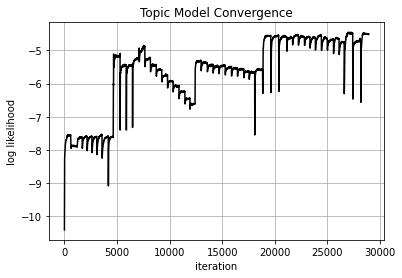

In [1015]:
p = re.compile("(-*\\d+\\.\\d+) per-word .* (\\d+\\.\\d+) perplexity")
matches = [p.findall(l) for l in open('gensim.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter,liklihood,c="black")
plt.ylabel("log likelihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.savefig("convergence_liklihood.pdf")
# plt.close()

In [146]:
def save_model(model, path):
    temp_file = datapath(path)
    model.save(temp_file)

In [39]:
def load_model(path):
    temp_file = datapath(path)
    return LdaModel.load(temp_file)

In [40]:
# save_model(lda_model, '22_topics')
lda_model = load_model('22_topics')

In [1017]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(3,
  '0.260*"management" + 0.126*"manager" + 0.117*"information_technology" + '
  '0.050*"level" + 0.040*"strategy" + 0.036*"implementation" + '
  '0.035*"leadership" + 0.022*"impact" + 0.019*"focus" + 0.018*"system"'),
 (16,
  '0.299*"data" + 0.108*"analyst" + 0.044*"management" + 0.035*"tableau" + '
  '0.034*"visualization" + 0.032*"bi" + 0.032*"mpi" + 0.030*"sql" + '
  '0.029*"dashboard" + 0.028*"reporting"'),
 (14,
  '0.296*"sql" + 0.236*"database" + 0.081*"oracle" + 0.071*"developer" + '
  '0.041*"programming" + 0.025*"data" + 0.018*"oracle_sql" + 0.016*"design" + '
  '0.015*"management" + 0.014*"reporting"'),
 (11,
  '0.272*"testing" + 0.159*"qa" + 0.147*"healthcare" + 0.095*"engineer" + '
  '0.047*"retail" + 0.037*"software" + 0.032*"quality_assurance" + '
  '0.018*"saas" + 0.013*"jira" + 0.013*"geospatial"'),
 (18,
  '0.174*"engineering" + 0.102*"engineer" + 0.100*"design" + 0.092*"system" + '
  '0.058*"electrical" + 0.017*"software" + 0.016*"electrical_engineering" + '
  '0.

In [626]:
def truncate(values):
    docs = {}
    for v in values:
        if v[1] > 1:
            res = v[1] - (trunc(v[1] - 0))
        else:
            res = v[1]
        docs[v[0]] = round(res, 7)
    return docs

In [627]:
#TODO: get detailed understanding of how phi-values are calculated to determine if bayesian inference is necessary here.
# Do the phi values include bayesian inference, or are they merely raw probabilities?
# is it necessary to multiply the phi-value (likelihood of a word coming from a topic) by the likelihood of the topic?

def bayesian_calc(a, b, b_given_a):
    return (b_given_a * a) / b

In [576]:
def tfidf_scores(tfidf_model, corpus, dictionary, doc):
    tfidf = {}
    scores = corpus[doc]
    for s in scores:
        tfidf[dictionary[s[0]]] = s[1]
    return tfidf

In [628]:
def word_scores(docs, phi, dictionary):
    """
    Generates word score with associated token, assuming only words that are associated with the winning topic. 
    Also includes edge cases of words not associated to winning topic but that show up meaningfully in the document.
    For example, 'RNA' doesn't belong to topic 14, but it could still be meaningful as a skill across 
    data science roles.
    
    Further experimentation should be done to include/exclude such edge cases. Thresholds could eliminate edge 
    cases anyway.
    """
#     top_topic = max(docs, key=lambda key: docs[key])
    scores = {}
    for doc_topic, doc_topic_prob in docs.items():
        for word_id, word_topic_prob in phi.items():
            if doc_topic in word_topic_prob.keys():
                # potentially implement bayesian_calc here instead of below calculation. 
                # Might end up being the same value
                scores[dictionary[word_id]] = word_topic_prob[doc_topic] * doc_topic_prob
                
    return scores

In [646]:
lda_training[(lda_training['job_description'].str.contains('target audience')) & (lda_training['matching_column'] == '.net_developer')]['job_description'].values[0]

"Role: .NET DeveloperLocation: Currently WFH (Dallas, Houston and Austin)Client: DirectDuration: Long termVisa: USC/ / GC- EAD/ -EAD/ CPT/ OPT Please share profiles to email:  .NET Developer Responsibilities:  Utilizing Microsoft's .NET infrastructure to create software solutions that meet clients' requirements. Collaborating with coworkers to facilitate the creation of large, complex developments, as required. Reformulating existing code to ensure adherence to stipulated guidelines. Checking your code to detect and remedy errors and omissions. Testing your outputs to ensure that they are in excellent working order. Ensuring that outputs are visually appealing, user-friendly, and engaging. Deploying developments and monitoring uptake by the target audience. Using clients' feedback to inform the creation of subsequent versions of each development. Remaining abreast of coding and technological changes that will impact your work.   .NET Developer Requirements: Degree in web design, softwa

In [1023]:
lda_training[(lda_training['job_description'].str.contains('target audience')) & (lda_training['matching_column'] == '.net_developer')]['skills_only'].values[0]

['.net',
 'developer',
 'gc',
 'cpt',
 '.net',
 'developer',
 '.net',
 'infrastructure',
 'software',
 'impact',
 '.net',
 'developer',
 'design',
 'software',
 'engineering',
 '.net',
 'developer',
 '.net',
 'infrastructure',
 'c',
 'sql',
 'oracle',
 'software',
 'management']

In [629]:
def jd_word_scores(lda_model, tfidf_model, dictionary, text, corpus):
#     bow = model.id2word.doc2bow(text)
    bow = corpus[text.name]
    doc_topics, _, phi_values = lda_model.get_document_topics(bow, per_word_topics=True)
    docs = truncate(doc_topics)
    phi = {}
    
    for k, v in dict(phi_values).items():
        phi[k] = truncate(v)

    scores = word_scores(docs, phi, id2word)
#     tfidf_weights = tfidf_scores(tfidf_model, corpus, dictionary, text.name)
    
#     for k, v in scores.items():
#         scores[k] = scores[k] * tfidf_weights[k]

    return [sorted(doc_topics, key=lambda x: x[1], reverse=True), scores]

In [1024]:
lda_training[['topics', 'word_scores']] = lda_training.progress_apply(lambda x: jd_word_scores(lda_model, tfidf, id2word, x, corpus), 
                                                                      axis=1,
                                                                      result_type='expand')

  0%|          | 0/10439 [00:00<?, ?it/s]

In [27]:
def plot_skill_dist(example, top_n=25, show_plot=False):
    scores = example['word_scores'].values[0]
    sort_scores = dict(sorted(scores.items(), key=itemgetter(1),reverse=True))
    if show_plot:
        fig, axs = plt.subplots(figsize = (20,10))
        t = example['matching_column'].values[0]
        title = f'Top {top_n} skills for {t}'
        skills = list(sort_scores.keys())[:top_n]
        likelihoods = list(sort_scores.values())[:top_n]
        plt.bar(skills, likelihoods, align='center', alpha=0.5)
        plt.xticks(skills, rotation=70)
        plt.ylabel('Likelihood')
        plt.title(title, size=20)
        plt.tick_params(labelsize=14)
        plt.show()
    return sort_scores

In [68]:
percentileofscore?

In [ ]:
all_percentiles = [percentileofscore(dataset, value, kind='strict') for value in dataset]

In [10]:
def get_avg(ws):
    length = len(ws.values)
    agg_dict = {}
    for i in ws.values:
        for k, v in i.items():
            if k not in agg_dict.keys():
                agg_dict[k] = {'sum': v, 'count': 1}
            else:
                agg_dict[k] = {'sum': agg_dict[k]['sum'] + v, 'count': agg_dict[k]['count'] + 1}

    for v in agg_dict.values():
        v['avg'] = v['sum'] / length
#         v['avg'] = v['sum'] / (length / v['count'])

    res_dict = {}

    for k, v in agg_dict.items():
#         res_dict[k] = {'score': agg_dict[k]['avg'], 'count': agg_dict[k]['count']}
        res_dict[k] = v['avg']
#         res_dict[k]['count'] = agg_dict[k]['count']

    scores = list(res_dict.values())
    for k, v in res_dict.items():
        res_dict[k] = {'avg_likelihood': v, 'percentile': percentileofscore(scores, v, kind='strict')}
    
    return res_dict

In [6]:
lda_training = pd.read_csv('lda_training.csv')

In [7]:
lda_training['skills_only'] = lda_training.apply(lambda x: eval(x['skills_only']), axis=1)
lda_training['word_scores'] = lda_training.apply(lambda x: eval(x['word_scores']), axis=1)

In [8]:
lda_training['topics'] = lda_training.apply(lambda x: eval(x['topics']), axis=1)

In [15]:
grouped = pd.DataFrame(lda_training.groupby('matching_column')['word_scores'].agg(lambda x: get_avg(x))).reset_index()
grouped

,matching_column,word_scores
0,.net_developer,{'data': {'avg_likelihood': 0.0276336801342743...
1,account_manager,{'communication': {'avg_likelihood': 0.7239402...
2,agile_coach,{'consulting': {'avg_likelihood': 0.0024905443...
3,android_developer,{'education': {'avg_likelihood': 0.04636112049...
4,application_developer,{'professional': {'avg_likelihood': 0.01578110...
...,...,...
62,technical_writer,{'communication': {'avg_likelihood': 0.0579602...
63,ui_developer,"{'solid': {'avg_likelihood': 0.02271420261, 'p..."
64,ux_designer,{'communication': {'avg_likelihood': 0.0197308...
65,ux_researcher,{'data': {'avg_likelihood': 0.2182640219344722...


In [28]:
def sort_res_dict(data, sorted_col):
    one = operator.itemgetter(1)
    special = operator.itemgetter('score')

    return sorted(data.items(), key=lambda x: special(one(x)), reverse=True)

In [16]:
def plot_skill_dist(example, top_n=25, show_plot=False):
    scores = example['word_scores'].values[0]
    new_scores = {}
    for k, v in scores.items():
        new_scores[k] = v['avg_likelihood']
    sort_scores = dict(sorted(new_scores.items(), key=itemgetter(1),reverse=True))
    if show_plot:
        fig, axs = plt.subplots(figsize = (20,10))
        t = example['matching_column'].values[0]
        title = f'Top {top_n} skills for {t}'
        skills = list(sort_scores.keys())[:top_n]
        likelihoods = list(sort_scores.values())[:top_n]
        plt.bar(skills, likelihoods, align='center', alpha=0.5)
        plt.xticks(skills, rotation=70)
        plt.ylabel('Likelihood')
        plt.title(title, size=20)
        plt.tick_params(labelsize=14)
        plt.show()
    return sort_scores

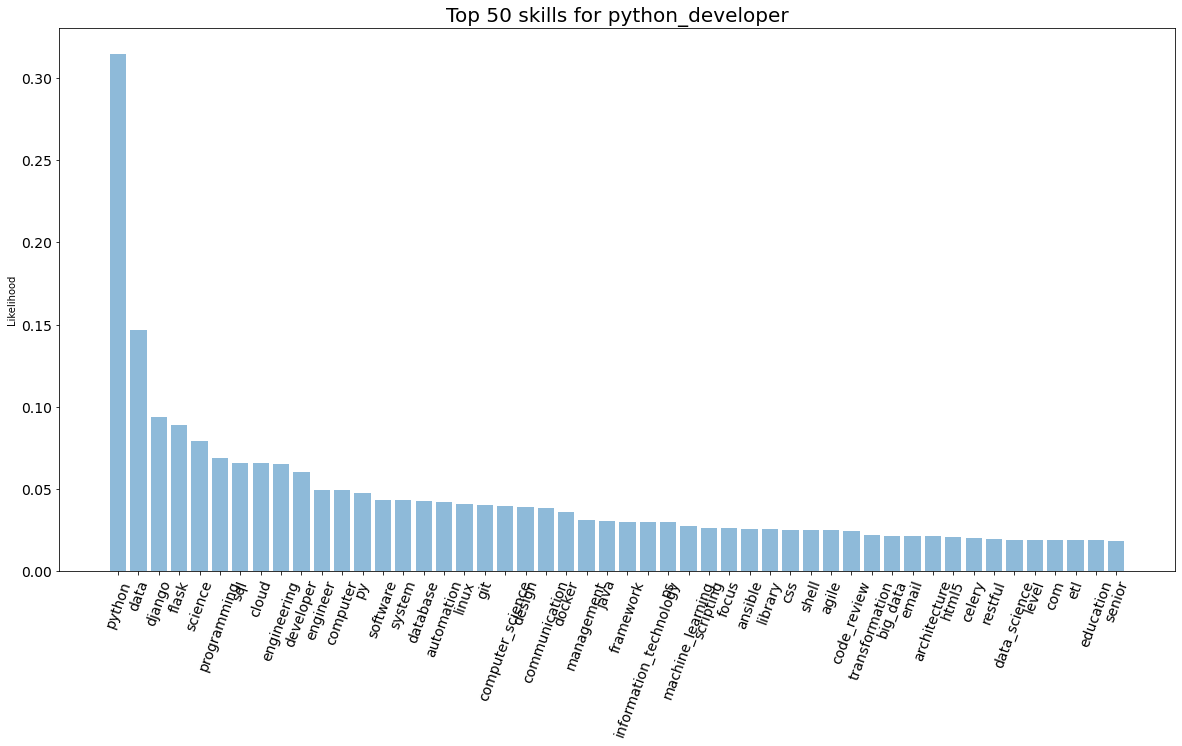

In [18]:
row = grouped[grouped['matching_column'] == 'python_developer']

sorted_python_skills = plot_skill_dist(row, top_n=50, show_plot=True)

In [19]:
# sorted_python_skills
res = {k: np.percentile(v, 95) for k, v in sorted_python_skills.items()}
res

{'python': 0.3146825533931457,
 'data': 0.14677868489249113,
 'django': 0.0937976834730003,
 'flask': 0.08915496139893449,
 'science': 0.07950374538859924,
 'programming': 0.06900071434109674,
 'sql': 0.06602209835107584,
 'cloud': 0.065612830889966,
 'engineering': 0.06553363342347349,
 'developer': 0.0603975149775737,
 'engineer': 0.04953444307119563,
 'computer': 0.04932032412047799,
 'py': 0.047548335747482746,
 'software': 0.043565483314746044,
 'system': 0.04316672195012499,
 'database': 0.04258017015947369,
 'automation': 0.04191680924000374,
 'linux': 0.041165577641856674,
 'git': 0.04036228746487407,
 'computer_science': 0.039779492240820113,
 'design': 0.03897602530657861,
 'communication': 0.03844919876157896,
 'docker': 0.03592929583408616,
 'management': 0.03114166219297489,
 'java': 0.030763915406513107,
 'framework': 0.030179979305263158,
 'information_technology': 0.029965268562646908,
 'ps': 0.029876132969792104,
 'machine_learning': 0.02783009740986306,
 'scripting': 

In [20]:
len(sorted_python_skills)

472

In [21]:
list(sorted_python_skills.values())[0]

0.3146825533931457

In [22]:
scores = list(sorted_python_skills.values())
for k, v in sorted_python_skills.items():
    sorted_python_skills[k] = {'avg_likelihood': v, 'percentile': percentileofscore(scores, v, kind='strict')}

In [23]:
sorted_python_skills

{'python': {'avg_likelihood': 0.3146825533931457,
  'percentile': 99.78813559322035},
 'data': {'avg_likelihood': 0.14677868489249113,
  'percentile': 99.57627118644068},
 'django': {'avg_likelihood': 0.0937976834730003,
  'percentile': 99.36440677966102},
 'flask': {'avg_likelihood': 0.08915496139893449,
  'percentile': 99.15254237288136},
 'science': {'avg_likelihood': 0.07950374538859924,
  'percentile': 98.9406779661017},
 'programming': {'avg_likelihood': 0.06900071434109674,
  'percentile': 98.72881355932203},
 'sql': {'avg_likelihood': 0.06602209835107584,
  'percentile': 98.51694915254238},
 'cloud': {'avg_likelihood': 0.065612830889966,
  'percentile': 98.30508474576271},
 'engineering': {'avg_likelihood': 0.06553363342347349,
  'percentile': 98.09322033898306},
 'developer': {'avg_likelihood': 0.0603975149775737,
  'percentile': 97.88135593220339},
 'engineer': {'avg_likelihood': 0.04953444307119563,
  'percentile': 97.66949152542372},
 'computer': {'avg_likelihood': 0.049320

In [60]:
limit = np.percentile(list(sorted_python_skills.values()), 95)
limit

0.030933901460420906

In [61]:
top_python_skills = dict(filter(lambda x: x[1]>limit, sorted_python_skills.items())) 
top_python_skills

{'python': 0.3146825533931457,
 'data': 0.14677868489249113,
 'django': 0.0937976834730003,
 'flask': 0.08915496139893449,
 'science': 0.07950374538859924,
 'programming': 0.06900071434109674,
 'sql': 0.06602209835107584,
 'cloud': 0.065612830889966,
 'engineering': 0.06553363342347349,
 'developer': 0.0603975149775737,
 'engineer': 0.04953444307119563,
 'computer': 0.04932032412047799,
 'py': 0.047548335747482746,
 'software': 0.043565483314746044,
 'system': 0.04316672195012499,
 'database': 0.04258017015947369,
 'automation': 0.04191680924000374,
 'linux': 0.041165577641856674,
 'git': 0.04036228746487407,
 'computer_science': 0.039779492240820113,
 'design': 0.03897602530657861,
 'communication': 0.03844919876157896,
 'docker': 0.03592929583408616,
 'management': 0.03114166219297489}

In [62]:
len(top_python_skills)

24

In [174]:
def top_skills(d, percentile, perc=False):
    word_scores = d['word_scores']
    scores = {k: round(v['avg_likelihood'], 4) for k, v in word_scores.items()}
    skills = dict(sorted(scores.items(), key=itemgetter(1), reverse=True))
    limit = np.percentile(list(skills.values()), percentile)
    top_skills = dict(filter(lambda x: x[1]>limit, skills.items())) 
    if perc:
        skills = {k: round(v['percentile'], 2) for k, v in word_scores.items()}
        top_skills = dict(filter(lambda x: x[1] > percentile/100, skills.items()))
        top_skills = dict(sorted(top_skills.items(), key=itemgetter(1), reverse=True))
    return top_skills

In [175]:
grouped['top_skills'] = grouped.apply(lambda x: top_skills(x, 95), axis=1)

In [169]:
grouped['top_skills_percentile'] = grouped.apply(lambda x: top_skills(x, 95, perc=True), axis=1)

In [165]:
grouped['top_skills_count'] = grouped.apply(lambda x: len(x['top_skills']), axis=1)

In [166]:
grouped['top_skills_count'].mean()

19.0

In [176]:
grouped = grouped.rename(columns={'matching_column': 'job_title'})
grouped

,job_title,word_scores,top_skills,top_skills_percentile,top_skills_count
0,.net_developer,{'data': {'avg_likelihood': 0.0276336801342743...,"{'.net': 0.3604, 'sql': 0.2677, 'c': 0.2452, '...","{'.net': 99.85, 'sql': 99.7, 'c': 99.55, 'deve...",34
1,account_manager,{'communication': {'avg_likelihood': 0.7239402...,"{'communication': 0.7239, 'management': 0.6581...","{'communication': 99.17, 'management': 98.33, ...",6
2,agile_coach,{'consulting': {'avg_likelihood': 0.0024905443...,"{'scrum': 0.6096, 'scrum_master': 0.4816, 'pro...","{'scrum': 99.51, 'scrum_master': 99.01, 'produ...",11
3,android_developer,{'education': {'avg_likelihood': 0.04636112049...,"{'android': 0.7041, 'kotlin': 0.5372, 'develop...","{'android': 99.75, 'kotlin': 99.51, 'developer...",21
4,application_developer,{'professional': {'avg_likelihood': 0.01578110...,"{'java': 0.1807, 'sql': 0.1527, 'c': 0.1312, '...","{'java': 99.73, 'sql': 99.47, 'c': 99.2, 'css'...",19
...,...,...,...,...,...
62,technical_writer,{'communication': {'avg_likelihood': 0.0579602...,"{'writing': 0.2489, 'technical_writing': 0.243...","{'writing': 99.73, 'technical_writing': 99.46,...",19
63,ui_developer,"{'solid': {'avg_likelihood': 0.02271420261, 'p...","{'ui': 0.4255, 'developer': 0.3249, 'css': 0.2...","{'ui': 99.7, 'developer': 99.4, 'css': 99.09, ...",17
64,ux_designer,{'communication': {'avg_likelihood': 0.0197308...,"{'sketch': 0.309, 'user_research': 0.1809, 're...","{'sketch': 99.67, 'user_research': 99.34, 'res...",16
65,ux_researcher,{'data': {'avg_likelihood': 0.2182640219344722...,"{'ux': 0.3854, 'user_research': 0.3155, 'usabi...","{'ux': 99.49, 'user_research': 98.98, 'usabili...",10


In [177]:
grouped['word_scores'] = grouped['word_scores'].astype('str')
grouped['word_scores'] = grouped['top_skills'].astype('str')
grouped['word_scores'] = grouped['top_skills_percentile'].astype('str')

In [179]:
grouped.to_csv('top_skills_by_job_title_percentiles.csv', index=False)

### TODO:
- handle edge cases for periods for tech skills, e.g., node.js is not getting captured, nor is node, just js
    - java is getting misinterrpreted as javascript 
- implement synonyms normalization for skills to augment tokens & n-grams
    - c#, c sharp, csharp => c#
- use knowledge graph relationships to augment skills as well
    - having "react" skills implies having strong javascript skills

In [1174]:
lda_training[lda_training['job_description'].str.contains('node.js')]['transformed_jds'].iloc[0]

['role',
 'web',
 'developer',
 'location',
 'los',
 'angeles',
 '%',
 'remote',
 'jd',
 'practical',
 'develop',
 'full',
 'stack',
 'software',
 'web',
 'application',
 'javascript',
 'react',
 'js',
 'oracle',
 'postgre',
 'sql',
 'express',
 'html',
 'css',
 'react',
 'ant',
 'design',
 'react',
 'hooks',
 'redux',
 'rest',
 'microservice']

In [1167]:
assert "java_script" in dhi_skills

AssertionError: 

In [443]:
t = lda_training[lda_training['matching_column'].str.contains('^java_developer', regex=True)].groupby('matching_column')['word_scores'].apply(lambda x: get_avg(x)).reset_index().sort_values('word_scores', ascending=False)

In [45]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.719185436312668

Coherence Score:  0.3889587717373754


In [46]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.

In [1037]:
lda_training[lda_training['top_topic'] == 14].iloc[:10][['matching_column', 'job_skills', 'skills_only', 'word_scores', 'top_topic']]

,matching_column,job_skills,skills_only,word_scores,top_topic
11,web_developer,"[ASP, ASP.NET, .NET, API, WEB]","[developer, healthcare, monitoring, system, wo...","{'system': 0.035214737, 'level': 0.04086683, '...",14
91,full_stack_java_developer,"[Java, Oracle, AWS]","[software, software, java, developer, java, or...","{'software': 0.016990975729984047, 'manager': ...",14
110,full_stack_java_developer,"[Java, Angular, SQL, Restful, MySQL]","[java, developer, programming, java, programmi...","{'leadership': 0.069510594, 'acquisition': 0.1...",14
863,python_developer,"[AWS, Python]","[python, developer, python, cloud, cloud, data...","{'data': 0.092223294, 'cloud': 0.0010083878, '...",14
873,python_developer,"[Python, AWS, SQL]","[python, developer, python, programming, apis,...","{'data': 0.06598433, 'software': 0.038980775, ...",14
919,python_developer,"[Python 3, BS/MS Computer Science with 2-4 yea...","[focus, manager, trading, python, developer, t...","{'focus': 0.026542831, 'manager': 0.022176936,...",14
927,python_developer,"[Python, SQL, ETL, Data Query, Linux, DevOps, ...","[python, developer, jersey, science, physics, ...","{'data': 0.12324814, 'programming': 0.24401888...",14
990,python_developer,"[Python, Amazon Web Services]","[python, developer, python, sql, python, devel...","{'data': 0.018593142, 'developer': 0.316211669...",14
1025,python_developer,"[python, unix]","[python, developer, oracle, testing]","{'developer': 0.28929305, 'python': 0.25107554...",14
1030,python_developer,"[Python, PAM]","[developer, management, programming, focus, pr...","{'programming': 0.28415561503196063, 'focus': ...",14


In [ ]:
row = pd.DataFrame(lda_training.groupby('matching_column')['word_scores'].agg(lambda x: get_avg(x))).reset_index().iloc[0]

plot_skill_dist(row, 25)

In [48]:
def get_top_topic(row):
    return max(row['topics'], key=itemgetter(1))[0]

In [54]:
lda_training['top_topic'] = lda_training.apply(get_top_topic, axis=1)

In [55]:
lda_training.to_csv('lda_training.csv')

In [233]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics, 
                         random_state=100,
#                          eval_every=1,
                         chunksize=100,
                         passes=15,
                         alpha='symmetric',
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

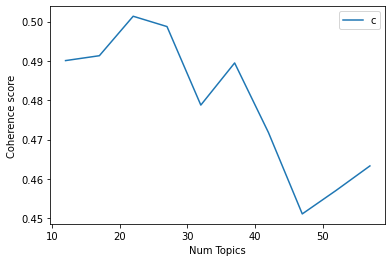

In [459]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=docs, start=12, limit=60, step=5)
# Show graph
limit=60; start=12; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [460]:
coherence_values

[0.4900974727240943,
 0.4913365809136838,
 0.5013724999020979,
 0.4987476535866511,
 0.4787853084379199,
 0.4894999955431844,
 0.471805419849436,
 0.4511150826741294,
 0.4570846374944924,
 0.4633193606656173]

In [461]:
model_list[2].num_topics

22

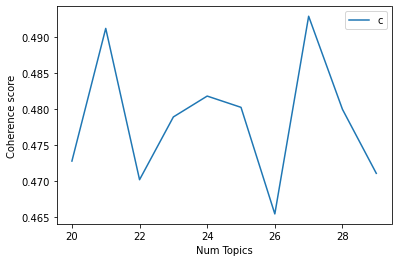

In [242]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=docs, start=20, limit=30, step=1)
# Show graph
limit=30; start=20; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Use 21 or 27 topics for highest coherence score